In [42]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as pyoff
import plotly.graph_objs as go
from pandas_profiling import ProfileReport
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgm
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

<b>Goal</b>

Employee turn-over is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

It is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is sometimes called people analytics or people data science (if you see a job title: people data scientist, this is your job).

In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn.


<b>Challenge Description</b>

We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.
As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:

Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.

<b>I -- What are the main factors that drive employee churn? Do they make sense? Explain your findings.>>>>?????</b>

<b>II -- If you could add to this data set just one variable that could help explain employee churn, what would that be? </b>


The table is: employee_retention - comprehensive information about employees. Columns:

<b>employee_id</b>: id of the employee. Unique by employee per company

company_id : company id.

dept : employee dept

seniority : number of yrs of work experience when hired

salary: avg yearly salary of the employee during her tenure within the company

join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13

quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)


In [2]:
path = "/Users/lethanhson/Documents/3_Learning/1. Machine Learing - AI/2.Vicohub/2.Thuctap/python-course/Mini Project 01-2020/employee_retention_data.csv"
df = pd.read_csv(path)
df

employee_id  company_id              dept  seniority    salary  \
0          13021.0           7  customer_service         28   89000.0   
1         825355.0           7         marketing         20  183000.0   
2         927315.0           4         marketing         14  101000.0   
3         662910.0           7  customer_service         20  115000.0   
4         256971.0           2      data_science         23  276000.0   
...            ...         ...               ...        ...       ...   
24697     549847.0           3  customer_service         16   97000.0   
24698     590087.0           4          engineer         10  160000.0   
24699     777612.0           4  customer_service         11   67000.0   
24700      97289.0          10          engineer         98  266000.0   
24701     604052.0           1         marketing         99  185000.0   

        join_date   quit_date  
0      2014-03-24  2015-10-30  
1      2013-04-29  2014-04-04  
2      2014-10-13         NaN  
3      2012-05-14  2013-06-07  
4      2011-10-17  2014-08-22  
...           ...         ...  
24697  2015-02-18         NaN  
24698  2015-10-26         NaN  
24699  2013-09-03  2015-10-23  
24700  2011-12-13  2015-01-09  
24701  2011-07-26  2013-12-06  

[24702 rows x 7 columns]

In [3]:
total_null = df.isna().sum().sort_values(ascending=False)
percent = 100*(df.isna().sum()/df.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent],
                         axis=1, keys=['Total', 'Percent'])
missing_data

Total    Percent
quit_date    11192  45.308072
join_date        0   0.000000
salary           0   0.000000
seniority        0   0.000000
dept             0   0.000000
company_id       0   0.000000
employee_id      0   0.000000

In [4]:
# Look around for employee information
print("Numbers Employee in the data : ", df['employee_id'].shape[0])
print("Unique Employee :", df.employee_id.nunique())
print("Unique Departments :", df['dept'].nunique())
print('Company IDs: ', df.company_id.nunique())

Numbers Employee in the data :  24702
Unique Employee : 24702
Unique Departments : 6
Company IDs:  12


In [5]:
# make column to identify who still work
df['employed'] = df['quit_date'].isnull().astype(int)

In [6]:
# make column to check date of quit
df['quit_check'] = df['quit_date']
df['quit_check'].fillna('2015-12-14', inplace=True)
df.head(10)

employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   
5     509529.0           4      data_science         14  165000.0  2012-01-30   
6      88600.0           4  customer_service         21  107000.0  2013-10-21   
7     716309.0           2  customer_service          4   30000.0  2014-03-05   
8     172999.0           9          engineer          7  160000.0  2012-12-10   
9     504159.0           1             sales          7  104000.0  2012-06-12   

    quit_date  employed  quit_check  
0  2015-10-30         0  2015-10-30  
1  2014-04-04         0  2014-04-04  
2         NaN         1  2015-12-14  
3  2013-06-07         0  2013-06-07  
4  2014-08-22         0  2014-08-22  
5  2013-08-30         0  2013-08-30  
6         NaN         1  2015-12-14  
7         NaN         1  2015-12-14  
8  2015-10-23         0  2015-10-23  
9         NaN         1  2015-12-14

In [7]:
# change the datetime to datatime
df['join_date'] = pd.to_datetime(df['join_date'])
df['quit_date'] = pd.to_datetime(df['quit_date'])
df['quit_check'] = pd.to_datetime(df['quit_check'])

In [8]:
# Check how long employee stay
df['stay'] = (df['quit_check'] - df['join_date']).astype('timedelta64[D]')
df

employee_id  company_id              dept  seniority    salary  \
0          13021.0           7  customer_service         28   89000.0   
1         825355.0           7         marketing         20  183000.0   
2         927315.0           4         marketing         14  101000.0   
3         662910.0           7  customer_service         20  115000.0   
4         256971.0           2      data_science         23  276000.0   
...            ...         ...               ...        ...       ...   
24697     549847.0           3  customer_service         16   97000.0   
24698     590087.0           4          engineer         10  160000.0   
24699     777612.0           4  customer_service         11   67000.0   
24700      97289.0          10          engineer         98  266000.0   
24701     604052.0           1         marketing         99  185000.0   

       join_date  quit_date  employed quit_check    stay  
0     2014-03-24 2015-10-30         0 2015-10-30   585.0  
1     2013-04-29 2014-04-04         0 2014-04-04   340.0  
2     2014-10-13        NaT         1 2015-12-14   427.0  
3     2012-05-14 2013-06-07         0 2013-06-07   389.0  
4     2011-10-17 2014-08-22         0 2014-08-22  1040.0  
...          ...        ...       ...        ...     ...  
24697 2015-02-18        NaT         1 2015-12-14   299.0  
24698 2015-10-26        NaT         1 2015-12-14    49.0  
24699 2013-09-03 2015-10-23         0 2015-10-23   780.0  
24700 2011-12-13 2015-01-09         0 2015-01-09  1123.0  
24701 2011-07-26 2013-12-06         0 2013-12-06   864.0  

[24702 rows x 10 columns]

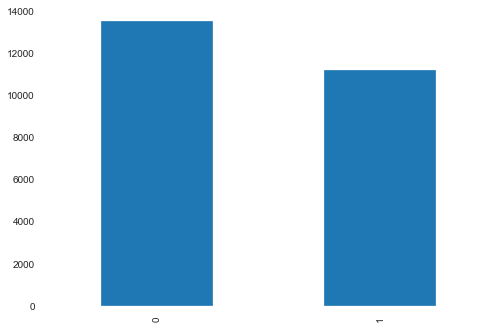

In [9]:
df['employed'].value_counts().sort_index().plot.bar()

Text(0.5, 0, 'Time which they stay')

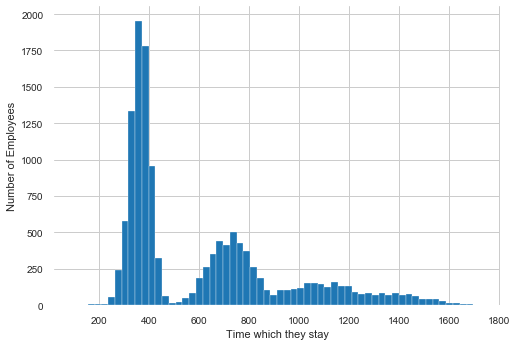

In [10]:
# Analyse the time which people ussualy stay with company
# employed = 0 is : quitted one
df.loc[df['employed'] == 0, 'stay'].hist(bins=60)
plt.ylabel('Number of Employees')
plt.xlabel('Time which they stay')

- There are about 3 groups in the chart
+ One group : a lot of people work for about a year then quit
+ Others : some people stayed for around 2 years then quit and the rest

Text(0, 0.5, 'Number of Employees')

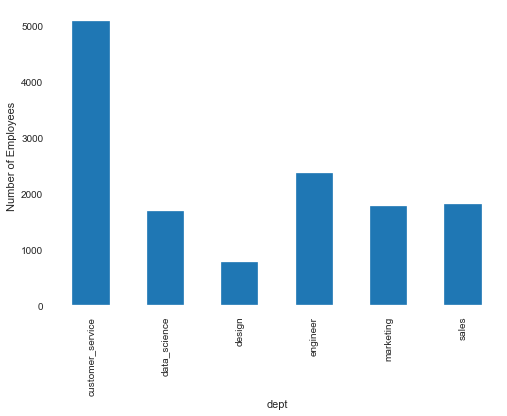

In [11]:
# Look at the Departments which they work
df.loc[df['employed'] == 0].groupby('dept')['dept'].count().plot.bar()
plt.ylabel('Number of Employees')

Most of people are from Customer_service department and engineer

Text(0, 0.5, 'Time they work for company by Departments')

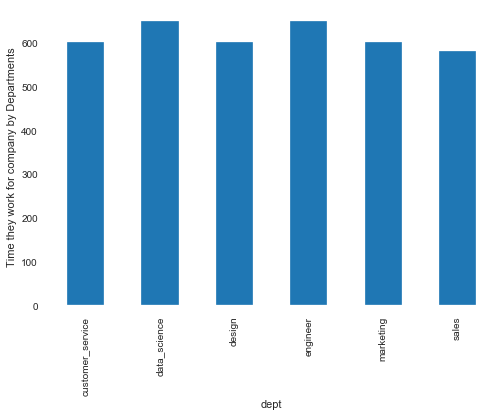

In [12]:
# 'Time they work for company by Departments'
df.loc[df['employed'] == 0].groupby('dept')['stay'].mean().plot.bar()
plt.ylabel('Time they work for company by Departments')

Text(0, 0.5, 'Time they work for company by Company')

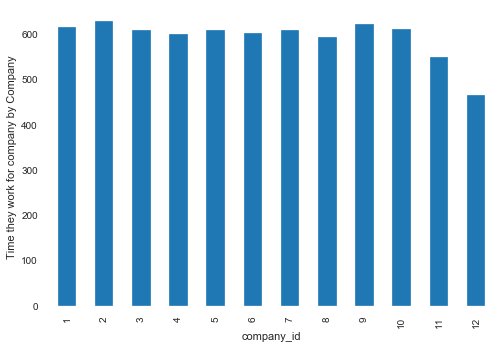

In [13]:
# 'Time they work for company by Company
df.loc[df['employed'] == 0].groupby('company_id')['stay'].mean().plot.bar()
plt.ylabel('Time they work for company by Company')

- Sale Dept have the shortest time with company
- Company 12 have some problem which keep the employee stay with them

Check the correlation between salary and time they work at company

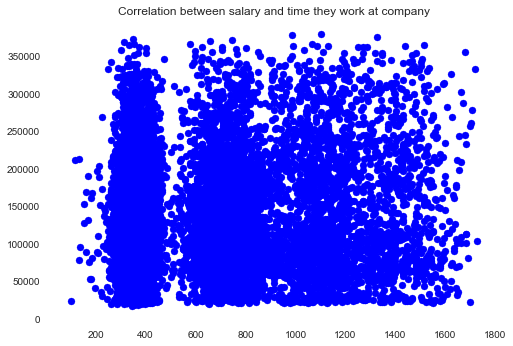

In [14]:
plt.title('Correlation between salary and time they work at company')
y = df.loc[df['employed'] == 0, 'salary']
x = df.loc[df['employed'] == 0, 'stay']

plt.scatter(x, y, marker='o', c='b',)  # plot my data points

- There is one point which left company so soon ... This could be because the salary is too low
- The salary is above 350,000 which still have the employees quit jobs but not as much . However the distribution still high for 1st year and the next 2,3 year later

Seniority vs Survival time in the job:

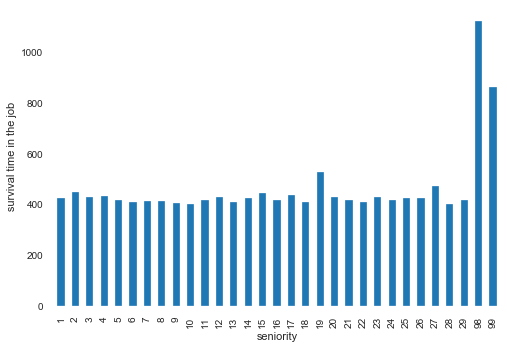

In [15]:
plt.ylabel('survival time in the job')
df.loc[df['employed'] == 0].groupby('seniority')['stay'].median().plot.bar()

Senority levels 98 and 99 could be the noise ( who can live until 98 and 99 years old and get hired then work for company for more than 3 , 4 years more ? )


In [16]:
df[(df['seniority'] == 98) | (df['seniority'] == 99)]

employee_id  company_id       dept  seniority    salary  join_date  \
24700      97289.0          10   engineer         98  266000.0 2011-12-13   
24701     604052.0           1  marketing         99  185000.0 2011-07-26   

       quit_date  employed quit_check    stay  
24700 2015-01-09         0 2015-01-09  1123.0  
24701 2013-12-06         0 2013-12-06   864.0

<b>Create columnd employee_headcount and look at the company size

In [17]:
# Our start and end dates
print(df['join_date'].max())
print(df['join_date'].min())

2015-12-10 00:00:00
2011-01-24 00:00:00


In [18]:
df_headcount = pd.DataFrame(columns=['day', 'company_id', 'employee_headcount']
                            )
for single_day in pd.date_range(start='2011/01/24', end='2015/12/13'):
    df_temp = pd.DataFrame(df[(df['join_date'] <= single_day) & (
        single_day < df['quit_check'])].groupby('company_id')['employee_id'].count())
    df_temp['day'] = single_day
    df_temp.rename(index=str, columns={
                   'employee_id': 'employee_headcount'}, inplace=True)
    df_temp.reset_index(inplace=True)
    df_headcount = df_headcount.append(df_temp)
df_headcount.set_index('day', inplace=True)
df_headcount

/Users/lethanhson/Documents/3_Learning/1. Machine Learing - AI/2.Vicohub/2.Thuctap/venv/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




company_id employee_headcount
day                                     
2011-01-24          1                 25
2011-01-24          2                 17
2011-01-24          3                  9
2011-01-24          4                 12
2011-01-24          5                  5
...               ...                ...
2015-12-13          8                468
2015-12-13          9                432
2015-12-13         10                385
2015-12-13         11                  4
2015-12-13         12                 12

[21335 rows x 2 columns]

company_id
1     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
Name: employee_headcount, dtype: object

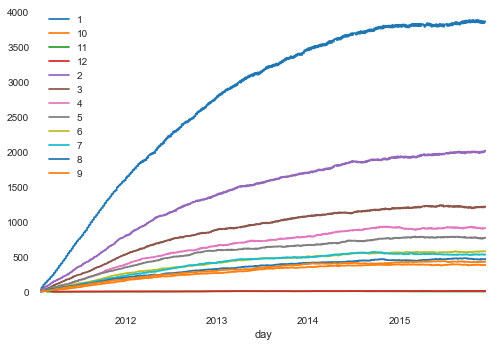

In [19]:
# companies = df['company_id'].unique()
companies = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
df_headcount[df_headcount['company_id'].isin(companies)].groupby('company_id')[
    'employee_headcount'].plot(legend=True)

company_id
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
Name: employee_headcount, dtype: object

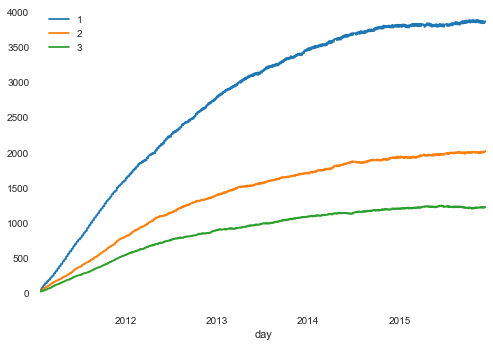

In [20]:
companies = ['1', '2', '3']
df_headcount[df_headcount['company_id'].isin(companies)].groupby('company_id')[
    'employee_headcount'].plot(legend=True)

company_id
10    AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
Name: employee_headcount, dtype: object

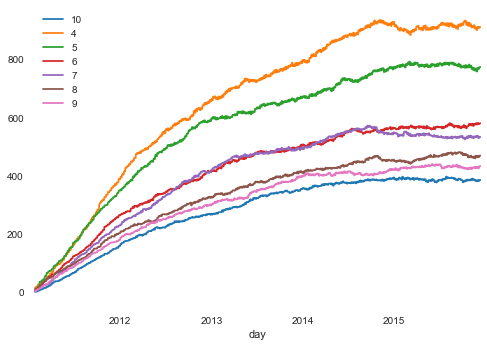

In [21]:
companies = ['4', '5', '6', '7', '8', '9', '10']
df_headcount[df_headcount['company_id'].isin(companies)].groupby('company_id')[
    'employee_headcount'].plot(legend=True)

company_id
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
Name: employee_headcount, dtype: object

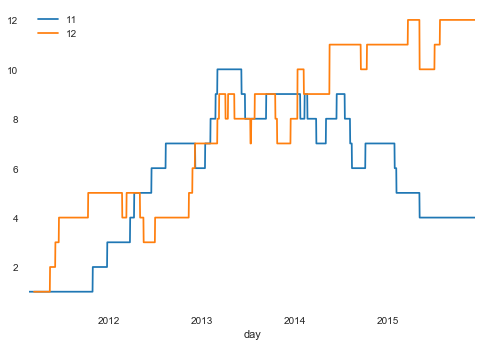

In [22]:
companies = ['11', '12']
df_headcount[df_headcount['company_id'].isin(companies)].groupby('company_id')[
    'employee_headcount'].plot(legend=True)

In [23]:
df[pd.to_datetime(df['join_date']) < pd.to_datetime(
    '2015-12-13')-pd.to_timedelta(396, unit='d')]

employee_id  company_id              dept  seniority    salary  \
0          13021.0           7  customer_service         28   89000.0   
1         825355.0           7         marketing         20  183000.0   
2         927315.0           4         marketing         14  101000.0   
3         662910.0           7  customer_service         20  115000.0   
4         256971.0           2      data_science         23  276000.0   
...            ...         ...               ...        ...       ...   
24695      63273.0           1      data_science          5  172000.0   
24696      94644.0           6         marketing          7   88000.0   
24699     777612.0           4  customer_service         11   67000.0   
24700      97289.0          10          engineer         98  266000.0   
24701     604052.0           1         marketing         99  185000.0   

       join_date  quit_date  employed quit_check    stay  
0     2014-03-24 2015-10-30         0 2015-10-30   585.0  
1     2013-04-29 2014-04-04         0 2014-04-04   340.0  
2     2014-10-13        NaT         1 2015-12-14   427.0  
3     2012-05-14 2013-06-07         0 2013-06-07   389.0  
4     2011-10-17 2014-08-22         0 2014-08-22  1040.0  
...          ...        ...       ...        ...     ...  
24695 2012-05-01 2015-06-26         0 2015-06-26  1151.0  
24696 2012-01-26 2013-02-01         0 2013-02-01   372.0  
24699 2013-09-03 2015-10-23         0 2015-10-23   780.0  
24700 2011-12-13 2015-01-09         0 2015-01-09  1123.0  
24701 2011-07-26 2013-12-06         0 2013-12-06   864.0  

[19270 rows x 10 columns]

Predict someone quit base on data could lead to less accuracy . So try to predict with conditions as data analysis above :There are 2 main time which people could quit their job. Before 400days (1 year 1 month) and after 

Text(0.5, 0, 'Time which they stay')

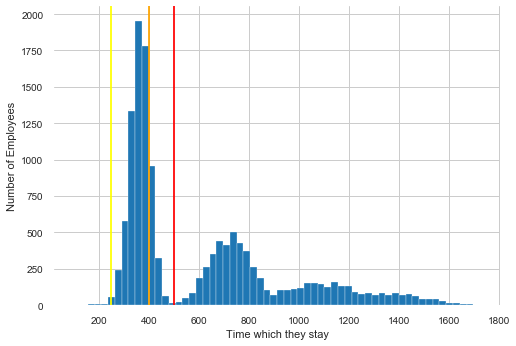

In [24]:
# Analyse the time which people ussualy stay with company
# employed = 0 is : quitted one
df.loc[df['employed'] == 0, 'stay'].hist(bins=60)
plt.axvline(x=500, color='red')
plt.axvline(x=400, color='orange')
plt.axvline(x=250, color='yellow')
plt.ylabel('Number of Employees')
plt.xlabel('Time which they stay')

In [25]:
def is_employed(row):
    if row['stay'] < 400:
        val = 1
    else:
        val = 0
    return val

In [26]:
df['predict'] = df.apply(is_employed, axis=1)
df

employee_id  company_id              dept  seniority    salary  \
0          13021.0           7  customer_service         28   89000.0   
1         825355.0           7         marketing         20  183000.0   
2         927315.0           4         marketing         14  101000.0   
3         662910.0           7  customer_service         20  115000.0   
4         256971.0           2      data_science         23  276000.0   
...            ...         ...               ...        ...       ...   
24697     549847.0           3  customer_service         16   97000.0   
24698     590087.0           4          engineer         10  160000.0   
24699     777612.0           4  customer_service         11   67000.0   
24700      97289.0          10          engineer         98  266000.0   
24701     604052.0           1         marketing         99  185000.0   

       join_date  quit_date  employed quit_check    stay  predict  
0     2014-03-24 2015-10-30         0 2015-10-30   585.0        0  
1     2013-04-29 2014-04-04         0 2014-04-04   340.0        1  
2     2014-10-13        NaT         1 2015-12-14   427.0        0  
3     2012-05-14 2013-06-07         0 2013-06-07   389.0        1  
4     2011-10-17 2014-08-22         0 2014-08-22  1040.0        0  
...          ...        ...       ...        ...     ...      ...  
24697 2015-02-18        NaT         1 2015-12-14   299.0        1  
24698 2015-10-26        NaT         1 2015-12-14    49.0        1  
24699 2013-09-03 2015-10-23         0 2015-10-23   780.0        0  
24700 2011-12-13 2015-01-09         0 2015-01-09  1123.0        0  
24701 2011-07-26 2013-12-06         0 2013-12-06   864.0        0  

[24702 rows x 11 columns]

In [27]:
df_dept = pd.get_dummies(df['dept'])
df = pd.concat([df, df_dept], axis=1)
df.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date  employed quit_check    stay  predict  customer_service  \
0 2015-10-30         0 2015-10-30   585.0        0                 1   
1 2014-04-04         0 2014-04-04   340.0        1                 0   
2        NaT         1 2015-12-14   427.0        0                 0   
3 2013-06-07         0 2013-06-07   389.0        1                 1   
4 2014-08-22         0 2014-08-22  1040.0        0                 0   

   data_science  design  engineer  marketing  sales  
0             0       0         0          0      0  
1             0       0         0          1      0  
2             0       0         0          1      0  
3             0       0         0          0      0  
4             1       0         0          0      0

In [28]:
cols = df.columns
cols = cols.drop(['stay', 'predict', 'dept',
                  'employee_id', 'join_date', 'quit_date','quit_check'])
cols

Index(['company_id', 'seniority', 'salary', 'employed', 'customer_service',
       'data_science', 'design', 'engineer', 'marketing', 'sales'],
      dtype='object')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    df[cols], df['predict'], test_size=0.33, random_state=5)

In [30]:
clf = DecisionTreeClassifier()
model = clf.fit(X_train, y_train)
pred = model.predict(X_test)

In [31]:
accuracy_score(pred, y_test)

0.5133709519136408

In [32]:
clf.feature_importances_

array([0.18619498, 0.29405892, 0.42805098, 0.01420096, 0.0072363 ,
       0.01712884, 0.0093754 , 0.01550863, 0.01320195, 0.01504304])

Feature important now is salary

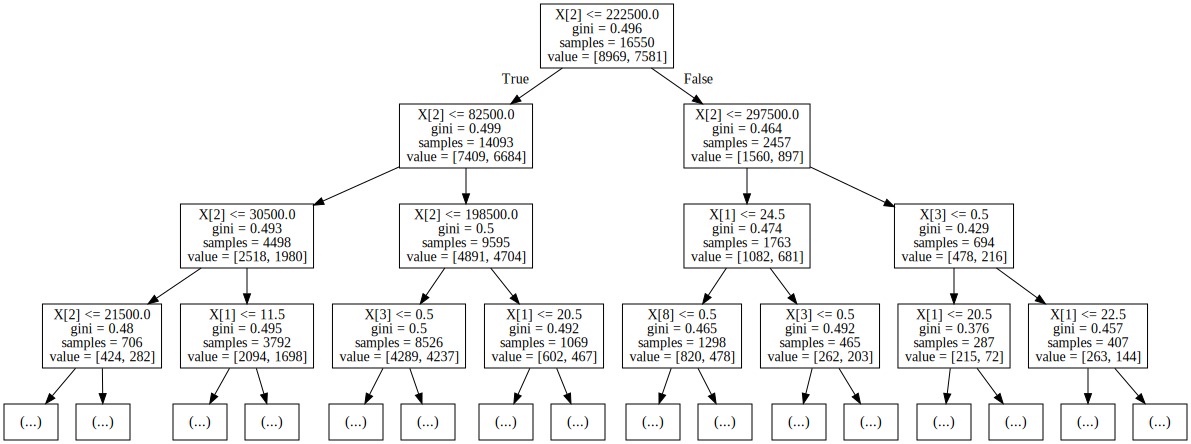

In [33]:
import graphviz 
from sklearn.tree import export_graphviz
dot_data = export_graphviz(clf, out_file=None, max_depth=3) 
graph = graphviz.Source(dot_data) 
graph

In [51]:
kf = KFold(n_splits=5, random_state=2020, shuffle=True)
oof_preds = np.zeros(X_train.shape[0])
test_preds = np.zeros(X_test.shape[0])
n_fold = 0
feature_importance_df = pd.DataFrame()
for train_idx, valid_idx in kf.split(X_train):
		train_x, train_y = X_train[cols].iloc[train_idx], y_train.iloc[train_idx]
		valid_x, valid_y = X_train[cols].iloc[valid_idx], y_train.iloc[valid_idx]
        
		model = LGBMClassifier(
			nthread=-1,
			n_estimators=2000,
			learning_rate=0.01,
			num_leaves=80,
			colsample_bytree=0.98,
			subsample=0.78,
			reg_alpha=0.04,
			reg_lambda=0.073,
			subsample_for_bin=50,
			boosting_type='gbdt',
			is_unbalance=True,
			min_split_gain=0.025,
			min_child_weight=40,
			min_child_samples=510,
			objective='binary',
			metric='auc',
			silent=-1,
			verbose=-1,
			feval=None)
        
		model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
		          eval_metric='gini',
		          verbose=1,
		          early_stopping_rounds=500)

		oof_preds[valid_idx] = model.predict_proba(
			valid_x, num_iteration=model.best_iteration_)[:, 1]
		test_preds += model.predict_proba(
			X_test[cols], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits

		fold_importance_df = pd.DataFrame()
		fold_importance_df["feature"] = cols
		fold_importance_df["importance"] = model.feature_importances_
		fold_importance_df["fold"] = n_fold + 1

		feature_importance_df = pd.concat(
			[feature_importance_df, fold_importance_df], axis=0)
		print('Fold %2d AUC : %.6f' %
		      (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
		del model, train_x, train_y, valid_x, valid_y

		n_fold = n_fold + 1
train_auc_score = roc_auc_score(y_train, oof_preds)
print('Full AUC score %.6f' % train_auc_score)

[1]	training's auc: 0.565121	valid_1's auc: 0.52917
Training until validation scores don't improve for 500 rounds
[2]	training's auc: 0.566821	valid_1's auc: 0.534685
[3]	training's auc: 0.566907	valid_1's auc: 0.531344
[4]	training's auc: 0.567084	valid_1's auc: 0.534487
[5]	training's auc: 0.567322	valid_1's auc: 0.535465
[6]	training's auc: 0.567376	valid_1's auc: 0.533917
[7]	training's auc: 0.567747	valid_1's auc: 0.536201
[8]	training's auc: 0.567706	valid_1's auc: 0.5359
[9]	training's auc: 0.567697	valid_1's auc: 0.535597
[10]	training's auc: 0.567937	valid_1's auc: 0.53661
[11]	training's auc: 0.567809	valid_1's auc: 0.536375
[12]	training's auc: 0.568076	valid_1's auc: 0.536941
[13]	training's auc: 0.568146	valid_1's auc: 0.537418
[14]	training's auc: 0.567908	valid_1's auc: 0.536431
[15]	training's auc: 0.568122	valid_1's auc: 0.53727
[16]	training's auc: 0.568163	valid_1's auc: 0.537182
[17]	training's auc: 0.568221	valid_1's auc: 0.537284
[18]	training's auc: 0.568139	vali

<b>Question about adding features</b>

    If I could add one feature to the dataset, I would add employee satisfaction, as it might help explain the peaks/troughs in the quitting percentile. 
    Then, I would add information about whether an employee is getting a bonus at the end of their year. 
    This might explain why there is a large peak of people quitting after their first year, and then a second peak after their second year. 
    With the information on whether they get a bonus, it might explain why there are some employees who quit after 
    their second year instead of after their first (if they don't get a bonus the first year).